# Задача 5. Обучение без учителя

* **Дедлайн**: 14.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- При обучении использовать **подбор гиперпараметров**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

## [Dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist)
Fashion‑MNIST – это набор данных, состоящий из изображений модной одежды компании Zalando, предназначенный для тестирования алгоритмов машинного обучения. Основные характеристики датасета:

Датасет разделён на обучающую выборку (60 000 примеров) и тестовую выборку (10 000 примеров). Каждый пример представляет собой изображение в градациях серого размером 28×28 пикселей, что даёт в сумме 784 признака (пикселя).

В изображениях каждый пиксель имеет значение от 0 до 255, где более высокое число соответствует более тёмному оттенку. При этом данные представлены в виде таблицы с 785 колонками: первая колонка – метка класса (тип одежды), а последующие 784 – значения интенсивности пикселей. В датасете 10 классов, каждый из которых соответствует определённой категории одежды (например, футболка/топ, брюки, свитер, платье, пальто, сандалии, рубашка, кроссовки, сумка, ботинки).

In [13]:
import kagglehub
import pandas as pd
import numpy as np
import pathlib
import itertools
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_random_state

In [14]:
# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

df = pd.read_csv(filepath_or_buffer=path + "/fashion-mnist_test.csv", dtype=np.uint8)
X = df.drop(columns=["label"])
y = df["label"]
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
y.value_counts().sort_index()

label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64

Итого у нас 10 классов, в которых одинаковое количество элементов, кластеры должны быть также одинаковы.

## EDA
Мы визуализируем данные, применив методы уменьшения размерности, а затем определим, насколько можно сократить число признаков, сохраняя при этом существенную часть информации.
### PCA и t-SNE


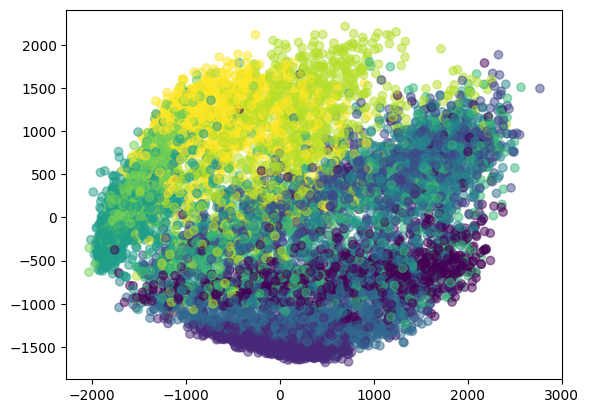

In [16]:
pca = PCA()
pca_res = pca.fit_transform(df)

plt.scatter(pca_res[:,0], pca_res[:,1], c=y, alpha=0.5)

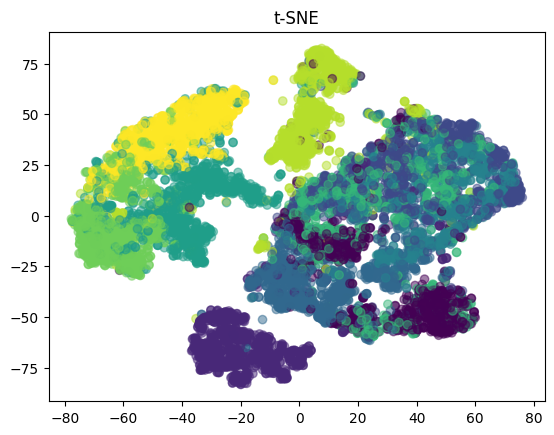

In [17]:
tsne_res = TSNE().fit_transform(df)
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y, alpha=0.5)
plt.title('t-SNE');

На первой визуализации, где использовался PCA видно, что кластеры хорошо разделены по краям, но в центральной области наблюдается смешение цветов, что затрудняет визуальное разделение кластеров. Во второй визуализации, где использовался t-SNE, ситуация улучшилась – можно выделить 10 отдельных кластеров, хотя в одной зоне всё ещё присутствует наложение точек разных цветов, скорее всего это происходит из-за специфики самого датасета.

### Понижение размерности 

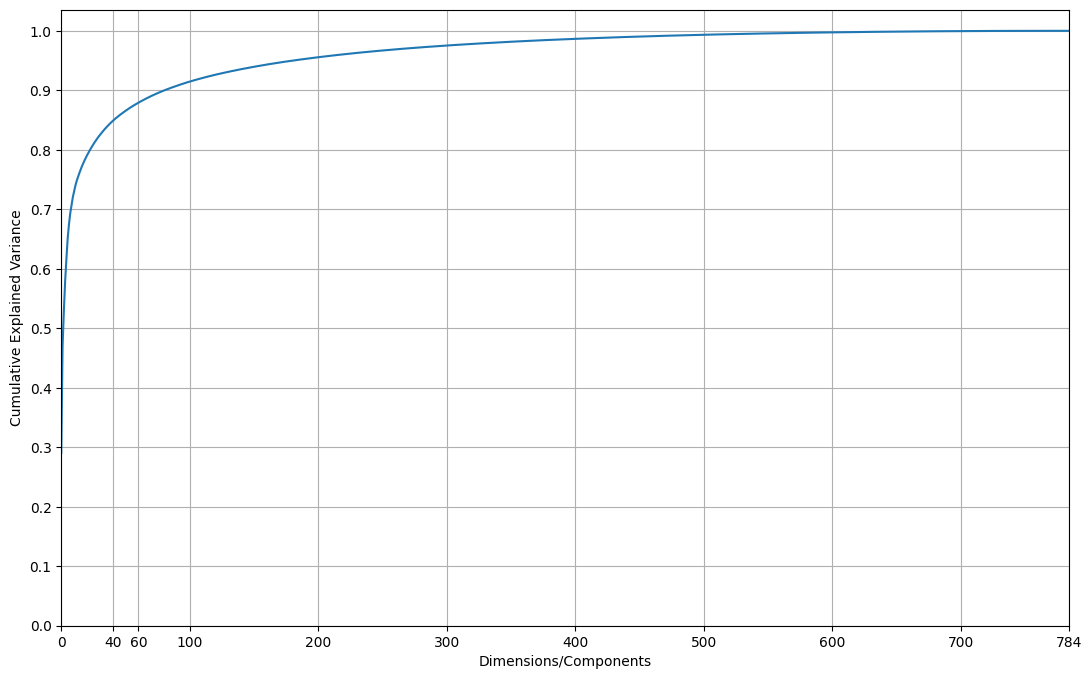

In [18]:
plt.figure(figsize=(13, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Dimensions/Components")
plt.ylabel("Cumulative Explained Variance")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks([*plt.xticks()[0], 40, 60, 28 * 28])
plt.xlim(0, 28 * 28)
plt.grid(True)
plt.show()

Можно заметить, что при уменьшении размерности до 40 признаков удается сохранить около 85% дисперсии, при 60 — более 87%, а при 100 — свыше 90%. При этом, начиная с 500 измерений, добавление новых признаков почти не добавляется новой информации.

## KMeans

In [19]:
class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, num_clusters=10, tolerance=1e-4, seed=None):
        self.num_clusters = num_clusters
        self.tolerance = tolerance
        self.seed = seed

    def fit(self, data, labels=None):
        self.num_clusters = int(self.num_clusters)
        self.tolerance = float(self.tolerance)
        self.random_state_ = check_random_state(self.seed)
        data = check_array(data)
        self.num_features_ = data.shape[1]
        
        self.centroids_ = data[
            self.random_state_.choice(len(data), size=self.num_clusters, replace=False), :
        ]
        
        max_shift = np.inf
        while max_shift > self.tolerance:
            self.labels_ = self._assign_clusters(data)  
            
            new_centroids = np.array([
                np.mean(data[self.labels_ == i], axis=0)
                for i in range(self.num_clusters)
            ])
            
            max_shift = np.max(np.linalg.norm(self.centroids_ - new_centroids, axis=1))
            self.centroids_ = new_centroids
        
        return self


    def predict(self, data):
        check_array(data)
        return self._assign_clusters(data)
    
    def _assign_clusters(self, data):
        return np.argmin(
            np.linalg.norm(data[..., None] - self.centroids_.T, axis=1), axis=1
        )


### Подбор параметров
Для оценки качества моделей кластеризации на датасете изображений одежды были выбраны три метрики и дополнительно замерялось время обучения.

+ **Adjusted Rand Index (ARI)**

    Измеряет степень совпадения истинных и предсказанных кластеров, оценивая точность попарного разделения объектов, при этом он не зависит от нумерации кластеров и учитывает случайные совпадения.
+ **Adjusted Mutual Information (AMI)** 

    Вычисляет количество общей информации между двумя разбиениями, скорректированное с учётом случайных совпадений, и подходит для анализа моделей с разным количеством кластеров.
+ **Fowlkes-Mallows Index (FMI)**

    Является гармоническим средним точности и полноты кластеризации, позволяя одновременно учитывать, насколько хорошо алгоритм выявляет внутреннюю структуру и избегает лишних разделений.
    
Дополнительно измерялось среднее время обучения для оценки эффективности алгоритмов с точки зрения вычислительных затрат.

In [20]:
data_sets = [df]
for n_dims in [40, 60, 100, 500]:
    transformed = PCA(n_components=n_dims).fit_transform(df)
    data_sets.append(transformed)

output_path = pathlib.Path("clustering_results.csv")

def create_param_grid(params_dict):
    if not params_dict:
        return [{}]
    keys = list(params_dict.keys())
    values = list(params_dict.values())
    return [dict(zip(keys, combo)) for combo in itertools.product(*values)]

def run_clustering_evaluation(model, params_dict):
    results = []
    param_grid = create_param_grid(params_dict)
    for data in data_sets:
        best_metrics = {
            'ari': (-np.inf, None), 
            'ami': (-np.inf, None), 
            'fmi': (-np.inf, None)
        }
        for params in param_grid:
            model_instance = clone(model).set_params(**params)
            start_time = time.perf_counter()
            preds = model_instance.fit_predict(data)
            elapsed = time.perf_counter() - start_time
            metrics = {
                'ari': adjusted_rand_score(y, preds),
                'ami': adjusted_mutual_info_score(y, preds),
                'fmi': fowlkes_mallows_score(y, preds)
            }
            for key, value in metrics.items():
                if value > best_metrics[key][0]:
                    best_metrics[key] = (value, elapsed, params)
        avg_time = np.mean([best_metrics[m][1] for m in best_metrics])
        record = {
            "model": model.__class__.__name__,
            "dimensions": data.shape[1],
            "avg_runtime": avg_time,
            "ari": best_metrics['ari'][0],
            "ami": best_metrics['ami'][0],
            "fmi": best_metrics['fmi'][0],
        }
        print(record)
        results.append(record)
    return results

all_results = []
evaluations = [
    (CustomKMeans(num_clusters=10, seed=0), {}),
    (KMeans(n_clusters=10, n_init='auto', random_state=0), {"algorithm": ["lloyd", "elkan"]}),
    (DBSCAN(n_jobs=-1), {"eps": [400, 800, 1200], "min_samples": [20, 40, 80]})
]

In [21]:
for model_obj, params in evaluations:
    model_results = run_clustering_evaluation(model_obj, params)
    all_results.extend(model_results)

results_df = pd.DataFrame(all_results)
results_df.to_csv(output_path, mode="a", header=not output_path.exists(), index=False)

{'model': 'CustomKMeans', 'dimensions': 785, 'avg_runtime': 27.07646726499661, 'ari': 0.3721012428341076, 'ami': 0.5183141838785751, 'fmi': 0.43891774939689665}
{'model': 'CustomKMeans', 'dimensions': 40, 'avg_runtime': 1.1664278249954805, 'ari': 0.35853146369916594, 'ami': 0.4924220376243029, 'fmi': 0.4257136336443439}
{'model': 'CustomKMeans', 'dimensions': 60, 'avg_runtime': 1.2749330080041545, 'ari': 0.35910690483225466, 'ami': 0.4928068949338498, 'fmi': 0.4262352242339165}
{'model': 'CustomKMeans', 'dimensions': 100, 'avg_runtime': 2.3551217220010585, 'ari': 0.3593607983451883, 'ami': 0.49289494946752094, 'fmi': 0.4264923524259291}
{'model': 'CustomKMeans', 'dimensions': 500, 'avg_runtime': 14.283708610004396, 'ari': 0.3593834287098087, 'ami': 0.4929431144968216, 'fmi': 0.42652077024966184}
{'model': 'KMeans', 'dimensions': 785, 'avg_runtime': 0.8522776649988373, 'ari': 0.34256596502877057, 'ami': 0.5012002207210654, 'fmi': 0.4130117288554663}
{'model': 'KMeans', 'dimensions': 40,

## Результаты

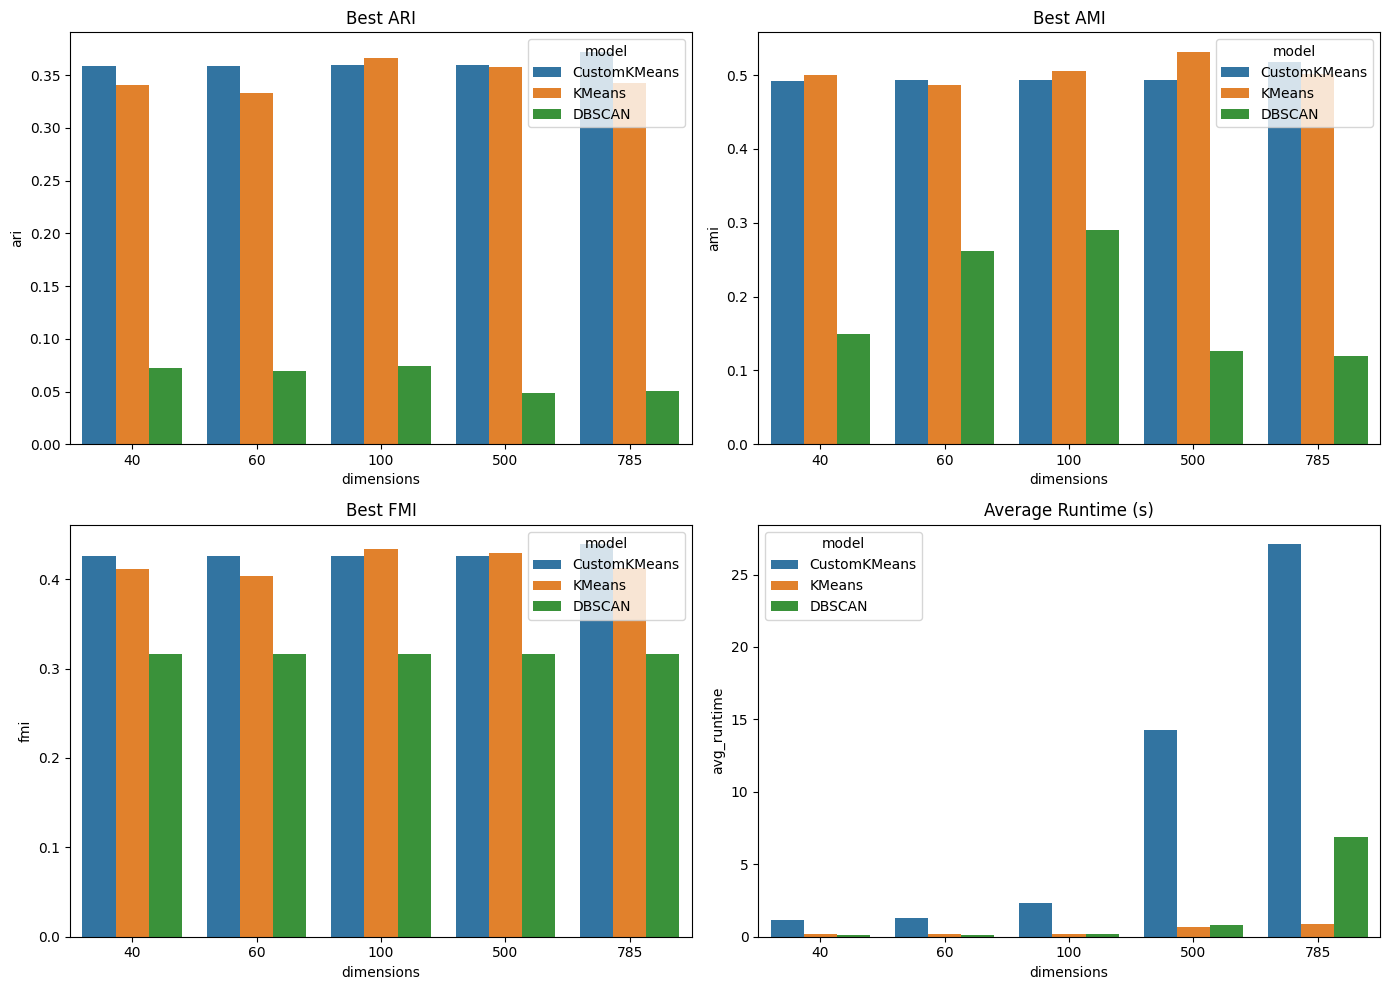

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
metrics_list = ['ari', 'ami', 'fmi', 'avg_runtime']
titles = ["Best ARI", "Best AMI", "Best FMI", "Average Runtime (s)"]

for ax, metric, title in zip(axes, metrics_list, titles):
    sns.barplot(data=results_df, x='dimensions', y=metric, hue='model', ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

Анализ результатов позволяет сделать следующие выводы:

1. Применение PCA для уменьшения размерности не привело к ухудшению качества, но значительно сократило время обучения модели.

2. По всем показателям качества алгоритм KMeans (как в собственной реализации, так и в версии из scikit-learn) демонстрирует явное преимущество по сравнению с DBSCAN, хотя абсолютные результаты KMeans остаются далёкими от идеала.

3. С точки зрения скорости обучения, реализация KMeans из scikit-learn также работает быстрее, чем DBSCAN.